In [1]:
import numpy as np

In [2]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

In [3]:
# def array_viz(a, fmt='png'):
#     a = 255 - (a.astype(np.uint8) * 255)
#     f = BytesIO()
#     PIL.Image.fromarray(a).save(f, fmt)
#     return IPython.display.Image(data=f.getvalue())
# def showarray(a):
#     IPython.display.display(array_viz(a))

### Display Formatters

['Text',
 array([[1, 2],
        [3, 4]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 [(1,
   array([[0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
          [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
          [0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
          [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
          [1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
          [1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
          [0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 1, 0, 1, 0, 0, 1, 1]])),
  (2,
   array([[1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
          [1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
          [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
          [1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
          [1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
          [0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
          [0, 1, 0, 0, 0, 0, 1, 0, 1, 1],
          [1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
          [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]])),
  (3,
   array([[1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
          [0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
          [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
          [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
          [1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
          [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
          [0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
          [0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
          [1, 0, 1, 0, 0, 0, 0, 1, 1, 1]]))]]
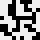
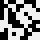
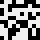

In [4]:
import html
html_formatter = get_ipython().display_formatter.formatters['text/html']

def bool_array_to_image(a, fmt='png'):
    a = 240 - (a.astype(np.uint8) * 240)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

def double_bitmap(a):
    (h, w) = a.shape
    return np.tile(a.reshape((-1, 1)), 2).reshape((h, w*2))

def quad_bitmap(a):
    return double_bitmap(double_bitmap(a).T).T

def ndarray_to_html(a):
    if len(a.shape) == 2 and a.max() <= 1 and a.min() >= 0:
        while a.size < 1024:
            a = quad_bitmap(a)
        
        for bundle in bool_array_to_image(a)._repr_mimebundle_():
            for mimetype, b64value in bundle.items():
                if mimetype.startswith('image/'):
                    src = f'data:{mimetype};base64,{b64value}'
                    return f'<img src="{src}">'
    else:
        return "<pre>{}</pre>".format(html.escape(repr(a)))

html_formatter.for_type(np.ndarray, ndarray_to_html)

def item_to_html(item):
    formatter = html_formatter.for_type(type(item))
    if callable(formatter):
        item = formatter(item)

    if callable(getattr(item, '_repr_mimebundle_', None)):
        for bundle in item._repr_mimebundle_():
            for mimetype, b64value in bundle.items():
                if mimetype.startswith('image/'):
                    src = f'data:{mimetype};base64,{b64value}'
                    return f'<img src={src}>'
    
    if not formatter:
        item = '<tt>{}</tt>'.format(html.escape(repr(item)))
    return f'<span style="margin-left:0.2em">{item}</span>'

def list_to_html(l):
    items = [item_to_html(item) for item in l]
    return '<tt style="display:flex;flex-wrap:wrap;align-items:center">[{}]</tt>'.format(', '.join(items))

html_formatter.for_type(list, list_to_html)

def tuple_to_html(l):
    items = (item_to_html(item) for item in l)
    return '<tt style="display:flex;flex-wrap:wrap;align-items:center">({})</tt>'.format(', '.join(items))

html_formatter.for_type(tuple, tuple_to_html)

["Text", np.array([[1,2],[3,4]]), np.eye(10), [(i, np.random.randint(0,2,(10,10))) for i in range(1,4)]]

## Part 1

In [5]:
tiles = {}
current_tile_id = None
current_tile = []

def make_tile_array(tile_text):
    tile_array = np.array([list(row) for row in tile_text]) == '#'
    return tile_array.astype(int)

with open("input.txt") as f:
    for line in f:
        line = line.strip()
        if line.startswith("Tile "):
            current_tile_id = int(line[4:-1])
            current_tile = []
        elif len(line) == 0:
            tiles[current_tile_id] = make_tile_array(current_tile)
        else:
            current_tile.append(line)

tile_ids = np.array(sorted(list(tiles.keys())))

[array([[1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0]]),
 array([[0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 1, 0]]),
 array([[0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 0]]),
 array([[0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 1, 0, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 1, 1, 1, 0, 1]]),
 array([[1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 1]]),
 array([[0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0]]),
 array([[1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1]]),
 array([[1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1
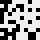
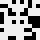
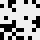
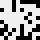
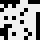
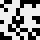
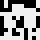
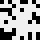
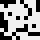
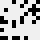
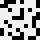
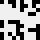
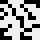
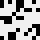
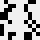
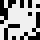
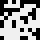
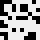
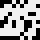
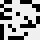
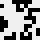
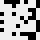
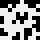
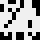
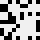
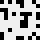
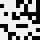
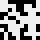
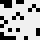
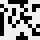
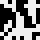
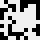
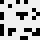
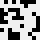
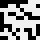
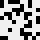
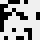
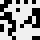
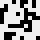
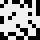
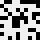
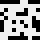
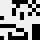
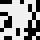
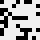
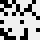
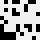
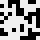
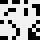
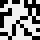
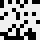
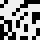
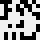
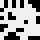
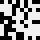
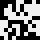
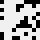
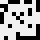
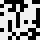
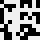
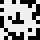
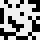
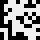
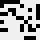
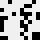
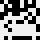
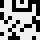
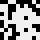
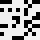
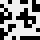
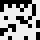
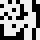
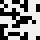
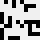
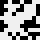
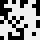
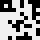
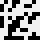
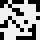
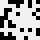
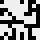
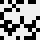
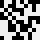
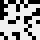
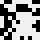
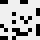
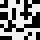
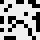
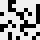
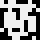
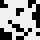
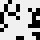
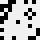
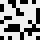
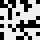
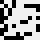
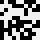
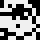
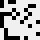
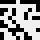
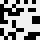
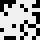
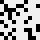
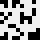
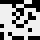
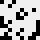
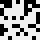
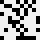
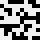
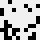
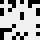
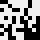
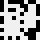
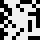
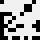
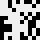
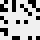
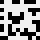
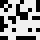
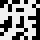
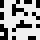
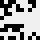
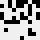
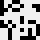
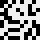
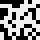
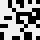
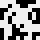
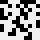
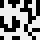
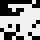
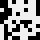
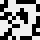
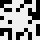
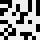
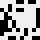
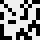
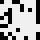
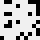
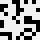
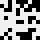
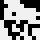
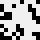
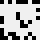

In [6]:
[*tiles.values()]

In [7]:
tile = tiles[tile_ids[0]]
print(tile)

[[1 1 1 1 0 0 0 0 0 1]
 [1 0 1 0 0 1 0 0 1 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 1]
 [0 0 0 1 0 1 0 1 1 0]
 [1 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 1]
 [0 1 1 1 0 1 0 0 1 0]]


In [8]:
def normalize_edge(edge):
    a = np.packbits(edge).view(np.uint16)[0]
    b = np.packbits(np.flip(edge)).view(np.uint16)[0]
    return a
[normalize_edge(x) for x in tile]

[16624, 49316, 130, 49216, 16384, 16386, 32789, 16516, 16386, 32884]

[array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 0]]),
 array([[1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 0, 0]]),
 array([[0, 1, 0, 0, 1, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 1]]),
 array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 1, 1, 1, 0, 1, 1]]),
 array([[1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 1, 0]]),
 array([[0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]]),
 array([[0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 1]]),
 array([[1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]])]
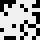
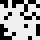
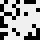
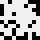
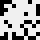
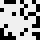
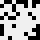
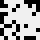

In [9]:
def apply_rot(tile, rot_type):
    if rot_type <= 0:
        return tile
    elif rot_type < 4:
        return apply_rot(np.rot90(tile), rot_type-1)
    else:
        return apply_rot(tile.T, rot_type-4)

[apply_rot(tile, i) for i in range(8)]

In [10]:
def get_edge_sigs(tile):
    edges = [apply_rot(tile, i)[0] for i in range(8)]
    # edges = [ tile[ 0,: ], tile[: ,-1], np.flip(tile[ 0,: ]), np.flip(tile[: ,-1]), tile[-1,: ], tile[: , 0], np.flip(tile[: , 0]), np.flip(tile[-1,: ]) ]
    return np.array([normalize_edge(e) for e in edges])

np.array([get_edge_sigs(apply_rot(tile, i)) for i in range(8)])

array([[16624, 32989, 32843, 49185,   225, 32884, 49262, 49283],
       [32989, 32843, 49185, 16624, 49283,   225, 32884, 49262],
       [32843, 49185, 16624, 32989, 49262, 49283,   225, 32884],
       [49185, 16624, 32989, 32843, 32884, 49262, 49283,   225],
       [  225, 32884, 49262, 49283, 16624, 32989, 32843, 49185],
       [32884, 49262, 49283,   225, 49185, 16624, 32989, 32843],
       [49262, 49283,   225, 32884, 32843, 49185, 16624, 32989],
       [49283,   225, 32884, 49262, 32989, 32843, 49185, 16624]],
      dtype=uint16)

In [11]:
tile_edges = np.array([get_edge_sigs(tiles[tile_id]) for tile_id in tile_ids])
tile_edges[0:5]

array([[16624, 32989, 32843, 49185,   225, 32884, 49262, 49283],
       [32986, 16501,   193, 49246, 32990, 49184, 32939, 49238],
       [16566, 32906, 16428, 49364, 49354,   141, 16468, 16539],
       [16388, 49292, 49285, 32981, 49258, 16616, 16588,   136],
       [32818, 32769, 16482, 32941, 16493, 32913,    96,    83]],
      dtype=uint16)

In [12]:
def find_num_matching_borders():
    unique, index, inverse, counts = np.unique(tile_edges, return_index=True, return_inverse=True, return_counts=True)
    matches = counts[inverse].reshape((-1,8))
    return matches
num_border_matches = find_num_matching_borders()
num_border_matches[:5]

array([[2, 1, 2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 1, 2, 2, 1, 2, 2],
       [2, 2, 1, 2, 2, 1, 2, 2]])

In [13]:
corners = np.sum(num_border_matches, axis=1) == 12
corner_ids = tile_ids[corners]
corner_ids

array([1109, 1693, 2909, 3371])

### Part 1 Solution

In [14]:
np.product(corner_ids)

18411576553343

## Part 2

In [15]:
monster = make_tile_array(
    ['                  # ',
     '#    ##    ##    ###',
     ' #  #  #  #  #  #   '])
monster

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]])

[array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 0]]),
 array([[0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]])]
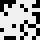

In [16]:
def remove_borders(tile):
    return tile[1:-1, 1:-1]
[tile, remove_borders(tile)]

In [17]:
len(tile_ids)

144

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1]])
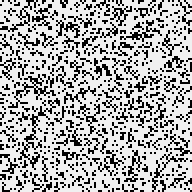

In [18]:
picture = np.vstack([np.hstack([remove_borders(tiles[id]) for id in tile_ids[12*i:12*i+12]]) for i in range(12) ])
quad_bitmap(picture)

In [19]:
get_edge_sigs(apply_rot(tiles[1109], 0))

array([   84, 32774, 16391,   238, 49181,   184,    88, 32778],
      dtype=uint16)

In [20]:
np.array([get_edge_sigs(apply_rot(tiles[1181], i)) for i in range(8)])

array([[49198,   216,     8, 32774,    88,     4, 49158,   221],
       [  216,     8, 32774, 49198,   221,    88,     4, 49158],
       [    8, 32774, 49198,   216, 49158,   221,    88,     4],
       [32774, 49198,   216,     8,     4, 49158,   221,    88],
       [   88,     4, 49158,   221, 49198,   216,     8, 32774],
       [    4, 49158,   221,    88, 32774, 49198,   216,     8],
       [49158,   221,    88,     4,     8, 32774, 49198,   216],
       [  221,    88,     4, 49158,   216,     8, 32774, 49198]],
      dtype=uint16)

In [21]:
rot_lookup_d = [0,1,2,3,4,5,6,7]
def find_next_tile_d(prev_tile_id, prev_rot_type):
    prev_tile = apply_rot(tiles[prev_tile_id], prev_rot_type)
    bot_border = prev_tile[-1:]
    bot_border_sig = normalize_edge(bot_border)
    border_matches, rot_type = np.where(tile_edges == bot_border_sig)
    match_tile_ids = tile_ids[border_matches]
    which = np.where(match_tile_ids != prev_tile_id)
    next_tile_id = match_tile_ids[which][0]
    rot = rot_lookup_d[rot_type[which][0]]
    return next_tile_id, rot
find_next_tile_d(1109, 0)

(1487, 6)

In [22]:
def build_col(first_tile_id, first_tile_rot):
    col = [(first_tile_id, first_tile_rot)]
    for _ in range(11):
        prev_tile_id, prev_rot = col[-1]
        next_tile_id, next_rot = find_next_tile_d(prev_tile_id, prev_rot)
        col.append((next_tile_id, next_rot))
#         prev_tile = apply_rot(tiles[prev_tile_id], prev_rot)
#         for i in range(8):
#             next_tile = apply_rot(tiles[next_tile_id], i)
#             if np.array_equal(prev_tile[-1,], next_tile[0,]):
#                 print(next_rot, i)
#                 col.append((next_tile_id, i))
    return col
jigsaw_left = build_col(1109,0)
jigsaw_left

[(1109, 0),
 (1487, 6),
 (3319, 6),
 (2423, 1),
 (2161, 5),
 (2999, 7),
 (1069, 6),
 (2371, 0),
 (3821, 7),
 (1523, 4),
 (3637, 7),
 (3371, 7)]

In [23]:
rot_lookup = [4,7,6,5,0,3,2,1]
def find_next_tile(prev_tile_id, prev_rot_type):
    prev_tile = apply_rot(tiles[prev_tile_id], prev_rot_type)
    right_border = prev_tile[:,-1]
    right_border_sig = normalize_edge(right_border)
    border_matches, rot_type = np.where(tile_edges == right_border_sig)
    match_tile_ids = tile_ids[border_matches]
    which = np.where(match_tile_ids != prev_tile_id)
    next_tile_id = match_tile_ids[which][0]
    rot = rot_lookup[rot_type[which][0]]
    return next_tile_id, rot
find_next_tile(1109, 0)

(1181, 5)

In [24]:
def build_row(first_tile_id, first_tile_rot):
    row = [(first_tile_id, first_tile_rot)]
    for _ in range(11):
        prev_tile_id, prev_rot = row[-1]
        next_tile_id, next_rot = find_next_tile(prev_tile_id, prev_rot)
        row.append((next_tile_id, next_rot))
#         prev_tile = apply_rot(tiles[prev_tile_id], prev_rot)
#         for i in range(8):
#             next_tile = apply_rot(tiles[next_tile_id], i)
#             if np.array_equal(prev_tile[:,-1], next_tile[:, 0]):
#                 print(next_rot, i)
#                 row.append((next_tile_id, i))
    return row
jigsaw = [build_row(i,r) for (i,r) in jigsaw_left]
jigsaw[0]

[(1109, 0),
 (1181, 5),
 (2719, 7),
 (1373, 1),
 (1303, 1),
 (1637, 7),
 (3023, 1),
 (1447, 4),
 (1361, 3),
 (1019, 1),
 (1733, 7),
 (1693, 6)]

In [25]:
corner_ids

array([1109, 1693, 2909, 3371])

In [26]:
def get_inner_tile(tile_id, rot):
    tile = apply_rot(tiles[tile_id], rot)
    return remove_borders(tile)
get_inner_tile(1109, 0)

array([[0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1]])

(96, 96)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
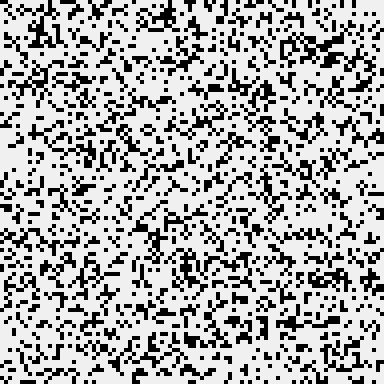

In [27]:
picture = np.vstack([
    np.hstack([get_inner_tile(i,r) for (i,r) in jigsaw[r]])
    for r in range(len(jigsaw))
])
print(picture.shape)
quad_bitmap(quad_bitmap(apply_rot(picture,2)))

In [28]:
with open("seas.png", "wb") as f:
    a = 255 - (apply_rot(picture,2).astype(np.uint8) * 255)
    PIL.Image.fromarray(a).save(f, "png")

In [29]:
print(monster.shape)
print(np.count_nonzero(monster))
monster

(3, 20)
15


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]])

In [30]:
def find_monster(sea):
    for r in range(8):
        num_found = 0
        p = apply_rot(sea, r)
        for i in range(p.shape[0] - monster.shape[0]):
            for j in range(p.shape[1] - monster.shape[1]):
                crop = p[i:i+monster.shape[0], j:j+monster.shape[1]]
                if np.array_equal(crop & monster, monster):
                    num_found += 1
#                     print("found", r, i, j)
        if num_found > 0:
            return num_found
find_monster(picture)

43

## Part 2 Solution

In [31]:
waters = np.count_nonzero(picture) - find_monster(picture) * np.count_nonzero(monster)
waters

2002

array([[1, 0, 0, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])
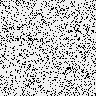

In [32]:
current_tile = []
with open("marked") as f:
    for line in f:
        current_tile.append(line.strip())

marked = make_tile_array(current_tile)
marked

array([[1, 0, 0, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])
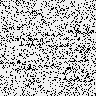

In [33]:
marked = marked | (np.array([list(row) for row in current_tile]) == 'O').astype(int)
marked

In [34]:
find_monster(marked)

12